# Análise da Bíblia
### Luís Guilheme Ribeiro

## Tarefas (TO DO)
- Entender todas as técnicas aplicada no notebook
- Pesquisar técnicas de NLP aplicáveis a este problema
- Traduzir para português br
- Definir um planejamento de EDA
- Realizar experimentação
- Preparar apresentação

## Tarefas realizadas pelo autor
* data enrichment - I introduce auxiliary data set with information about Biblical books
* cleaning - regular text cleaning with removal of interpuction
* stemming - I universalize the words minimizing them to just a stem
* lemmatization - grouping together the inflected forms of a word
* word clouds - plotting different parts of Bible and analysis of most frequent words
* unigrams, digrams, trigrams - the most frequent words, two-words, three-words phrases are plotted
* embedding - collective name for a set of language modeling and feature learning techniques
* BERT - I apply powerful and well-known model for this piece of text

O BERT (Bidirectional Encoder Representations from Transformers), 
é um modelo de representação de linguagem desenvolvido por pesquisadores do Google AI e
que teve seu código aberto em 2018

Análise de sentimento
https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0

### Técnicas comuns de NLP
- TFIDF: contagem de todas as palavras em um pedaço de texto;
- Tokenização: é a tarefa de cortar um texto em pedaços chamados tokens e, ao mesmo tempo, jogar fora alguns caracteres, como pontuação;
- Remover StopWords: eliminação de artigos, pronomes e preposições em idiomas comuns, como "e", "o", “a” em português;
- Lematização: resolve as palavras em sua forma de dicionário (Por exemplo, as palavras “correr", "corre" e "correu" são todas formas da palavra "correr", portanto "correr" é o lema de todas as palavras anteriores).

# 1.Data preparation

I will load in the libraries which I need to use. I also need to download one package which is not in standard Kaggle suite.

In [32]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from collections import Counter, defaultdict
import tokenization
import string

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

import operator, gc

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luisguilhermeribeiro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/luisguilhermeribeiro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/luisguilhermeribeiro/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Next, two data sets are loaded. First, the Bible text, where each record corresponds to one verse.

In [33]:
df_path = "./biblia_json_completa.csv"
df = pd.read_csv(df_path)
df.shape

(31482, 9)

Conjunto de dados auxiliar, contendo informações de época, período e localização, sobre os livros da bíblia

Palavras que não são tão interessante para a análise

In [34]:
sw = stopwords.words('portuguese')
print(sw[0:10])

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as']


Definição de algumas funções:

In [35]:
#Stemmers removem afixos morfológicos das palavras, deixando apenas o radical da palavra.
ps = PorterStemmer()

# converte para minúsculo
def lower_column_t(data):
    values = data['texto']
    values = values.lower()
    data['texto'] = values
    return data

#Limpa interrupções
def clean_interpunction(data):
    values = data['texto']
    values = values.replace('.','')
    values = values.replace(';','')
    values = values.replace(':','')
    values = values.replace(',','')
    values = values.replace("'","")
    values = values.replace('"','')
    data['texto'] = values
    return data

#Stemming é o processo de reduzir a inflexão em palavras para suas formas de raiz,
#como mapear um grupo de palavras para o mesmo radical,
#mesmo que o próprio radical não seja uma palavra válida no idioma.
# exemplo: amigos e amigas --> amig
def stem(a):
    p = nltk.PorterStemmer()
    b = []
    for line in a:

        split_line = line.split(' ')
        length=len(split_line)
        new_line = []

        for word in range(length):
            if word == 0:
                new_line.append(str(p.stem(split_line[word])))
            else:
                new_line[0] = new_line[0] + ' ' + (str(p.stem(split_line[word])))

        b.append(new_line[0])

    return b

#A lematização reduz as palavras flexionadas adequadamente, garantindo que a palavra raiz pertença ao idioma (dicionario)
# exemplo: amigos e amigas --> amigo
def lem(a):
    p = nltk.WordNetLemmatizer()
    b = []
    for line in a:

        split_line = line.split(' ')
        length=len(split_line)
        new_line = []

        for word in range(length):
            if word == 0:
                new_line.append(str(p.lemmatize(split_line[word], pos="v")))
            else:
                new_line[0] = new_line[0] + ' ' + (str(p.lemmatize(split_line[word], pos="v")))

        b.append(new_line[0])

    return b
# conta o texto e divide em tokens, removendo alguns caracteres como pontuações
def tokenize(a):  
    b = []
    for line in a:
        b.append(word_tokenize(line))         
    return b
# achatar as palvaras através do espaço
def flatten(a):
    b = []
    for line in a:
        b = ' '.join(line)
    return b

#Contagem de palavras
def count_words(a):
    b=0
    for line in a:
        b = b + sum([i.strip(string.punctuation).isalpha() for i in line.split()])
        
    return b

#N-grams são sequências contínuas de palavras ou símbolos ou tokens em um documento. 
#Em termos técnicos, eles podem ser definidos como sequências vizinhas de itens em um documentos
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in sw]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [36]:
# Tranformando os textos
df = df.apply(lower_column_t, axis=1)
df = df.apply(clean_interpunction, axis=1)
df['t_lem']=lem(df.texto)
df['t_stem']=stem(df.texto)
df['t_stem_lem']=lem(df.t_stem)
df['palavras'] = df['texto'].str.split().str.len()
df

,cod,livro,capitulo,versiculo,texto,tempo,periodo,localizacao,testamento,t_lem,t_stem,t_stem_lem,palavras
0,1,Genesis,1,1,no princípio criou deus os céus e a terra,-500,Persian,Israel,antigo,no princípio criou deus os céus e a terra,no princípio criou deu os céu e a terra,no princípio criou deu os céu e a terra,9
1,1,Genesis,1,2,e a terra era sem forma e vazia,-500,Persian,Israel,antigo,e a terra era sem forma e vazia,e a terra era sem forma e vazia,e a terra era sem forma e vazia,8
2,1,Genesis,1,3,e disse deus haja luz,-500,Persian,Israel,antigo,e disse deus haja luz,e diss deu haja luz,e diss deu haja luz,5
3,1,Genesis,1,4,e viu deus que era boa a luz,-500,Persian,Israel,antigo,e viu deus que era boa a luz,e viu deu que era boa a luz,e viu deu que era boa a luz,8
4,1,Genesis,1,5,e deus chamou à luz dia,-500,Persian,Israel,antigo,e deus chamou à luz dia,e deu chamou à luz dia,e deu chamou à luz dia,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31477,66,Apocalipse,22,17,e o espírito e a esposa dizem vem e quem ouve ...,95,Christian,Patmos,novo,e o espírito e a esposa dizem vem e quem ouve ...,e o espírito e a esposa dizem vem e quem ouv d...,e o espírito e a esposa dizem vem e quem ouv d...,18
31478,66,Apocalipse,22,18,porque eu testifico a todo aquele que ouvir as...,95,Christian,Patmos,novo,porque eu testifico a todo aquele que ouvir as...,porqu eu testifico a todo aquel que ouvir as p...,porqu eu testifico a todo aquel que ouvir as p...,33
31479,66,Apocalipse,22,19,e se alguém tirar quaisquer palavras do livro ...,95,Christian,Patmos,novo,e se alguém tirar quaisquer palavras do livro ...,e se alguém tirar quaisquer palavra do livro d...,e se alguém tirar quaisquer palavra do livro d...,31
31480,66,Apocalipse,22,20,aquele que testifica estas coisas diz certamen...,95,Christian,Patmos,novo,aquele que testifica estas coisas diz certamen...,aquel que testifica esta coisa diz certament c...,aquel que testifica esta coisa diz certament c...,14


In [37]:
# Conjunto auxiliar para realizar análises
df_aux = pd.read_csv("./data/BibleBooks.csv", encoding= 'unicode_escape')
df_enriched = df_aux.drop(['Tanakh','New Jerusalem Version', 'Book'], axis=1)
df_enriched['King James Version']=df_enriched['King James Version'].replace(np.nan, 0)
df_enriched['King James Version'] = df_enriched['King James Version'].astype('int')
df_enriched.rename(columns={"King James Version": "cod", "Period": "periodo", 'Time': 'tempo', 'Location': 'localizacao'},inplace=True)
df_enriched

,cod,tempo,periodo,localizacao
0,44,80,Christian,Rome
1,30,-745,Monarchic,Israel
2,0,-180,Hellenistic,Israel
3,13,-350,Persian,Israel
4,14,-350,Persian,Israel
...,...,...,...,...
68,56,100,Christian,Nicopolis
69,0,-200,Hellenistic,Israel
70,0,-50,Maccabean,Israel
71,38,-500,Persian,Israel


In [38]:
# Separando DF´s em novo e antigo testamento
df_novo = df[df['testamento'] == 'novo']
df_antigo = df[df['testamento'] == 'antigo']

# 2. Análise

- Como a extensão dos versículos evolui ao longo dos livros da Bíblia.
- Podemos estimar menos quando os livros foram escritos, mas é mais difícil entender qual foi o histórico e a localização do livro. 
- A extensão do verso nos dá muito conhecimento sobre a cultura subjacente e o pano de fundo por trás dele.

## 2.1 Conategens de palavras e versículos

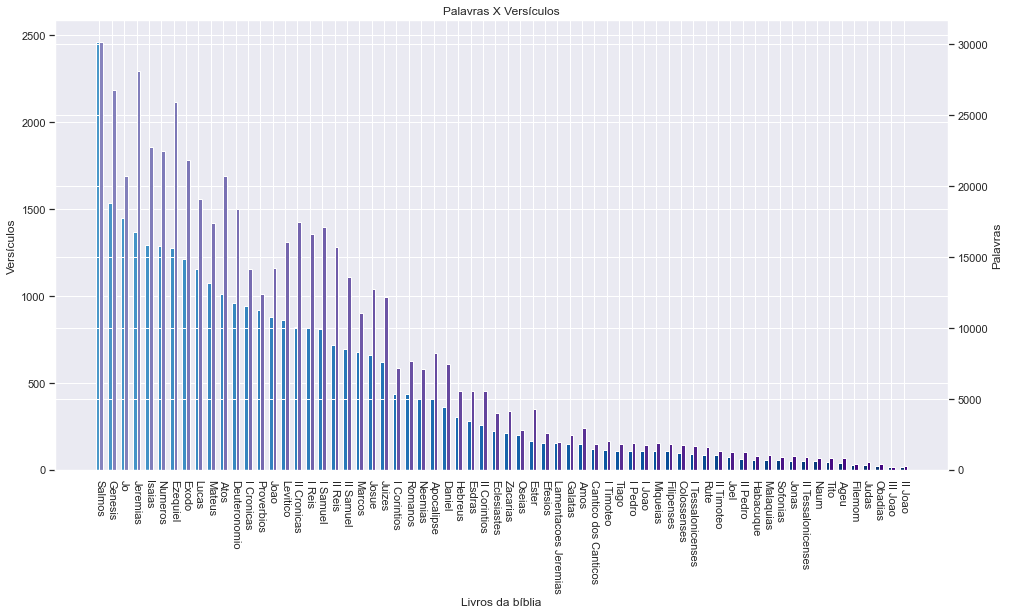

In [39]:
# Todos os livros
color_1 = plt.cm.Blues(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, 66))

df_agg = df.groupby('livro').agg({'livro':'count','palavras':'sum'})
df_agg['total'] = df_agg['livro']
words_versets = df_agg.sort_values(by='total',ascending=False)
data1 = words_versets['total']
data2 = words_versets['palavras']

plt.figure(figsize=(16,8))
x = np.arange(66)
ax1 = plt.subplot(1,1,1)
w = 0.3

color = color_1
plt.title('Palavras X Versículos')
plt.xticks(x + w /2, data1.index, rotation=-90)
ax1.set_xlabel('Livros da bíblia')
ax1.set_ylabel('Versículos')
ax1.bar(x,data1.values,color=color_1,width=w,align='center')

ax2 = ax1.twinx()

color = color_2
ax2.set_ylabel('Palavras')
ax2.bar(x + w,data2, color=color_2,width=w,align='center')

plt.show()

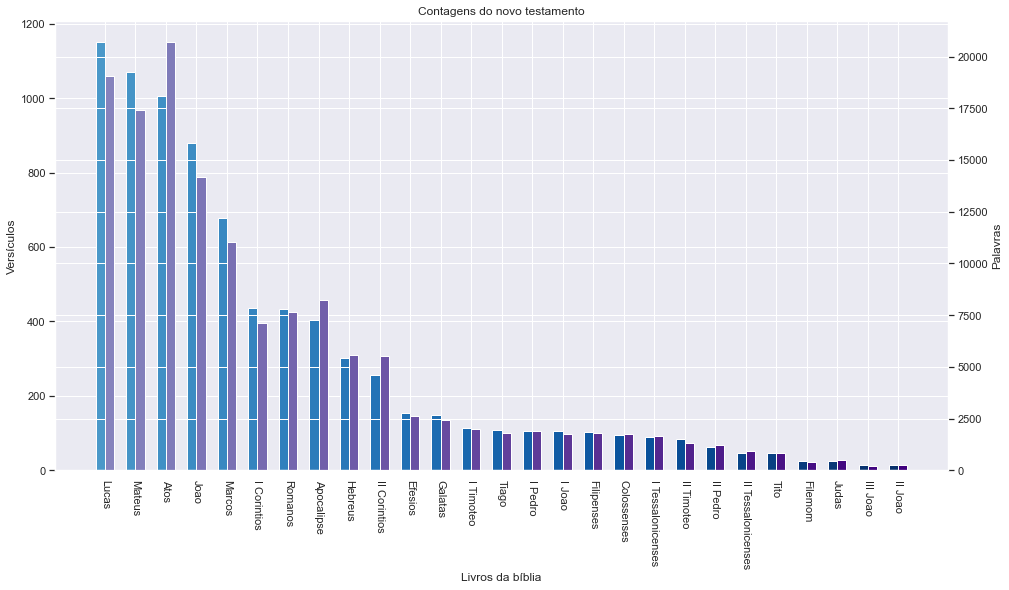

In [40]:
# Novo Testamento
tam = len(df_novo['livro'].unique())
color_1 = plt.cm.Blues(np.linspace(0.6, 1, tam))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, tam))

df_agg = df_novo.groupby('livro').agg({'livro':'count','palavras':'sum'})
df_agg['total'] = df_agg['livro']
words_versets = df_agg.sort_values(by='total',ascending=False)
data1 = words_versets['total']
data2 = words_versets['palavras']

plt.figure(figsize=(16,8))
x = np.arange(tam)
ax1 = plt.subplot(1,1,1)
w = 0.3

color = color_1
plt.title('Contagens do novo testamento')
plt.xticks(x + w /2, data1.index, rotation=-90)
ax1.set_xlabel('Livros da bíblia')
ax1.set_ylabel('Versículos')
ax1.bar(x,data1.values,color=color_1,width=w,align='center')

ax2 = ax1.twinx()

color = color_2
ax2.set_ylabel('Palavras')
ax2.bar(x + w,data2, color=color_2,width=w,align='center')

plt.show()

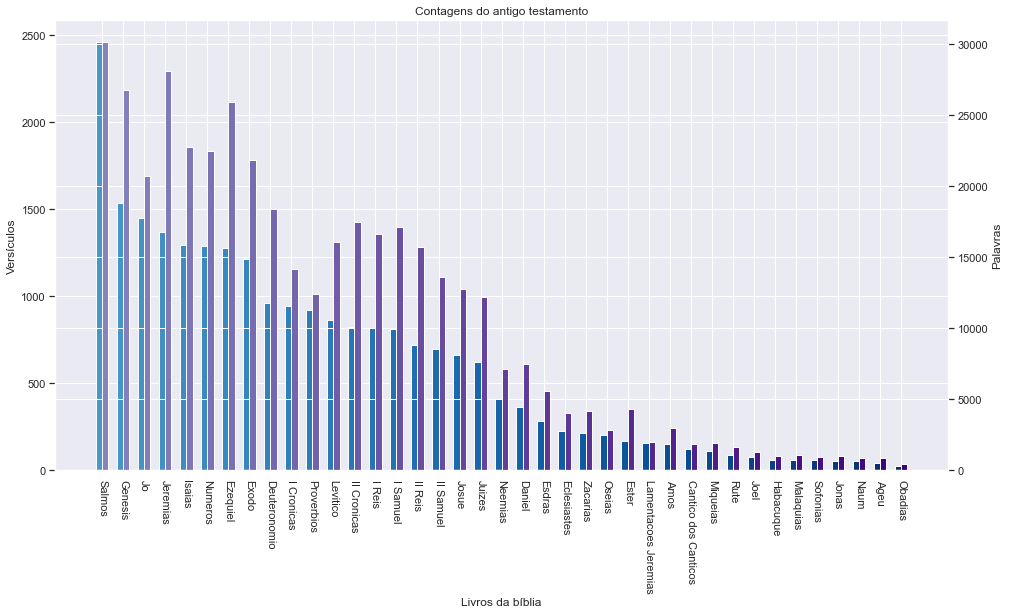

In [41]:
# Antigo Testamento
tam = len(df_antigo['livro'].unique())
color_1 = plt.cm.Blues(np.linspace(0.6, 1, tam))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, tam))

df_agg = df_antigo.groupby('livro').agg({'livro':'count','palavras':'sum'})
df_agg['total'] = df_agg['livro']
words_versets = df_agg.sort_values(by='total',ascending=False)
data1 = words_versets['total']
data2 = words_versets['palavras']

plt.figure(figsize=(16,8))
x = np.arange(tam)
ax1 = plt.subplot(1,1,1)
w = 0.3

color = color_1
plt.title('Contagens do antigo testamento')
plt.xticks(x + w /2, data1.index, rotation=-90)
ax1.set_xlabel('Livros da bíblia')
ax1.set_ylabel('Versículos')
ax1.bar(x,data1.values,color=color_1,width=w,align='center')

ax2 = ax1.twinx()

color = color_2
ax2.set_ylabel('Palavras')
ax2.bar(x + w,data2, color=color_2,width=w,align='center')

plt.show()

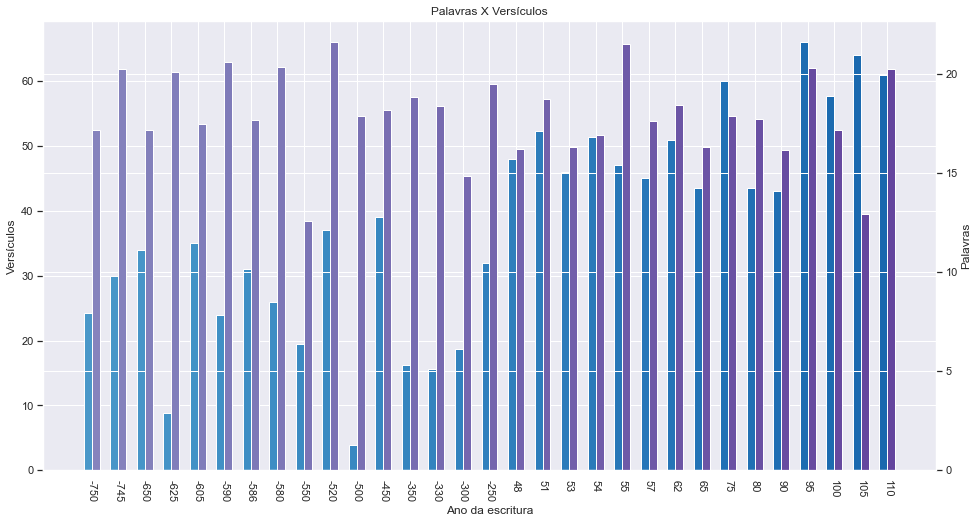

In [42]:
# Agrupando por tempo e realizando a contagem 
color_1 = plt.cm.Blues(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, 66))

words_versets_ = df.groupby('tempo').agg({'cod':'mean','palavras':'mean','tempo':'mean'})
data1 = words_versets_['cod']
data2 = words_versets_['palavras']

plt.figure(figsize=(16,8))
x = np.arange(31)
ax1 = plt.subplot(1,1,1)
w = 0.3

color = color_1
plt.title('Palavras X Versículos')
plt.xticks(x + w /2, data1.index, rotation=-90)
ax1.set_xlabel('Ano da escritura')
ax1.set_ylabel('Versículos')
ax1.bar(x,data1.values,color=color_1,width=w,align='center')

ax2 = ax1.twinx()

color = color_2
ax2.set_ylabel('Palavras')
ax2.bar(x + w,data2, color=color_2,width=w,align='center')

plt.show()

Fascinante observar a diferença entre a Bíblia AC e DC. É importante saber que o Novo Testamento foi escrito no chamado 'grego koiné', o número de palavras em cada versículo é muito maior do que em hebraico ou aramaico. E para cumprir nosso caçador de correlações, Spearman apresenta o seu melhor:

In [43]:
# DF auxiliar para mapear o codigo dos livros
df_livro = pd.DataFrame(data={'cod': df['cod'].unique(), 'livro': df['livro'].unique()})
df_livro

,cod,livro
0,1,Genesis
1,2,Exodo
2,3,Levitico
3,4,Numeros
4,5,Deuteronomio
...,...,...
61,62,I Joao
62,63,II Joao
63,64,III Joao
64,65,Judas


In [44]:
df_agg = df.groupby('cod').agg({'cod':'count','palavras':'sum'})
df_agg['versiculos'] = df_agg['cod']
df_agg.drop('cod', inplace=True, axis=1)
df_total = df_agg.sort_values(by='versiculos',ascending=False)
df_total.reset_index(inplace=True)

df_total['taxa_pv'] = round(df_total['palavras']/df_total['versiculos']).astype('int')
df_total = df_total.sort_values(by='taxa_pv',ascending=False)
df_merged = df_total.merge(df_enriched, left_on='cod', right_on='cod')
df_merged

,cod,palavras,versiculos,taxa_pv,tempo,periodo,localizacao
0,17,4277,167,26,-350,Persian,Persia
1,47,5507,256,22,55,Christian,Ephesus
2,12,15719,719,22,-625,Monarchic,Israel
3,37,821,38,22,-520,Persian,Israel
4,27,7470,357,21,-350,Persian,Babylon
...,...,...,...,...,...,...,...
61,28,2821,197,14,-750,Monarchic,Israel
62,18,20715,1446,14,-300,Hellenistic,Edom
63,25,1939,154,13,-550,Exilic,Israel
64,64,194,15,13,105,Christian,Ephesus


<AxesSubplot:>

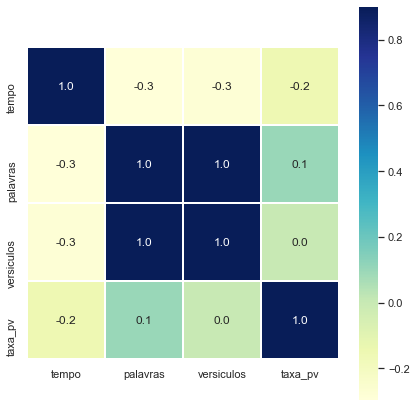

In [45]:
SpearmanCorr = df_merged[['tempo', 'palavras','versiculos', 'taxa_pv']].corr(method="spearman")
plt.figure(figsize=(7,7))
sns.heatmap(SpearmanCorr, vmax=.9, square=True, annot=True, linewidths=.3, cmap="YlGnBu", fmt='.1f')

In [46]:
df_merged_2 = df_merged.merge(df_livro, left_on='cod', right_on='cod')
df_merged_2.head()

,cod,palavras,versiculos,taxa_pv,tempo,periodo,localizacao,livro
0,17,4277,167,26,-350,Persian,Persia,Ester
1,47,5507,256,22,55,Christian,Ephesus,II Corintios
2,12,15719,719,22,-625,Monarchic,Israel,II Reis
3,37,821,38,22,-520,Persian,Israel,Ageu
4,27,7470,357,21,-350,Persian,Babylon,Daniel


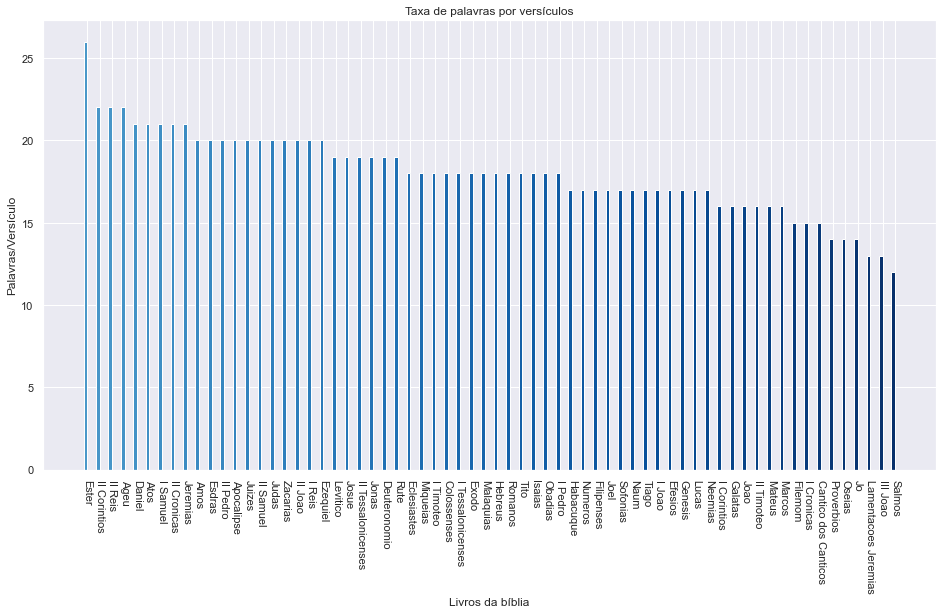

In [47]:
# Novo Testamento
tam = len(df_merged_2['livro'].unique())
color_1 = plt.cm.Blues(np.linspace(0.6, 1, tam))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, tam))

plt.figure(figsize=(16,8))
x = np.arange(tam)
ax1 = plt.subplot(1,1,1)
w = 0.3

color = color_1
plt.title('Taxa de palavras por versículos')
plt.xticks(x + w /2, df_merged_2.livro, rotation=-90)
ax1.set_xlabel('Livros da bíblia')
ax1.set_ylabel('Palavras/Versículo')
ax1.bar(x,df_merged_2.taxa_pv,color=color_1,width=w,align='center')


plt.show()

In [48]:
df_livro['autor'] = np.nan
df_livro.loc[44:56, 'autor'] = 'Paulo'
df_livro.loc[39, 'autor'] = 'Mateus'
df_livro.loc[40, 'autor'] = 'Marcos'
df_livro.loc[41, 'autor'] = 'Lucas'
df_livro.loc[42, 'autor'] = 'Joao'
df_livro.loc[43, 'autor'] = 'Lucas'
df_livro.loc[58, 'autor'] = 'Tiago'
df_livro.loc[59:60, 'autor'] = 'Pedro'
df_livro.loc[61:63, 'autor'] = 'Joao'
df_livro.loc[64, 'autor'] = 'Judas'
df_livro.loc[65, 'autor'] = 'Joao'

In [49]:
df = df.merge(df_livro[['cod', 'autor']], left_on='cod', right_on='cod')

## 2.2.Nuvens de palavras

Em seguida, eu olho para 4 nuvens de palavras. Nuvem de palavras é o conjunto das palavras que aparecem com mais frequência na forma de nuvem. Eu observo como meu texto mudou pela aplicação de diferentes métodos mencionados anteriormente:
* plain text
* lemmatization
* stemming
* stemming of lemmatised results

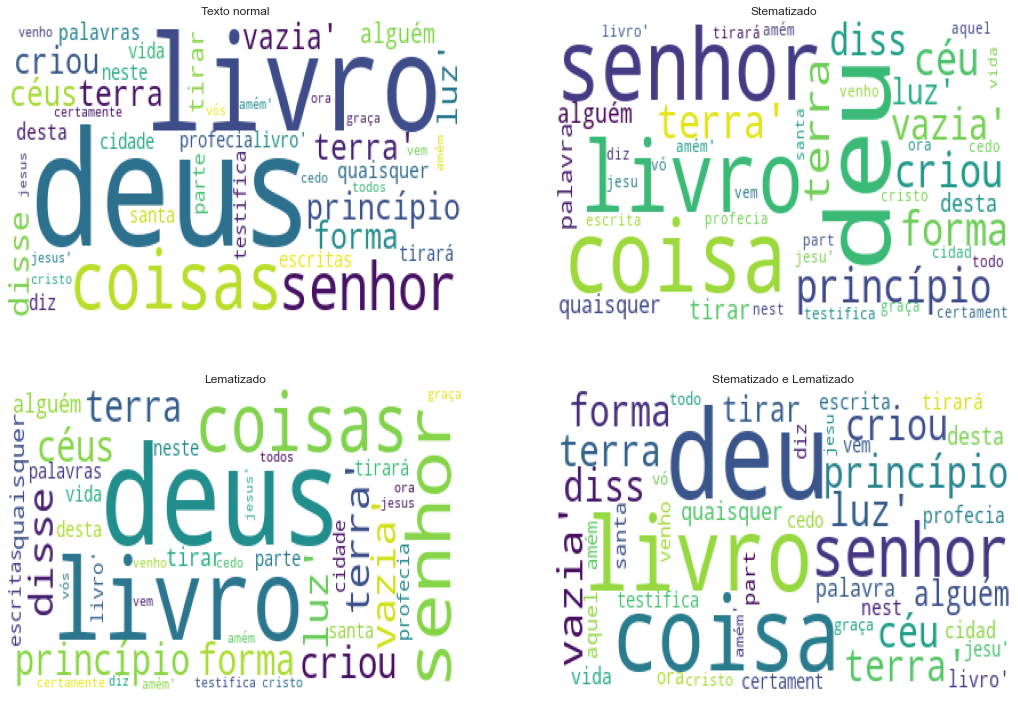

In [50]:
mpl.rcParams['figure.figsize']=(10,10)    
mpl.rcParams['font.size']=12                        
mpl.rcParams['figure.subplot.bottom']=.1 

wordcloud_t = WordCloud(background_color='white',stopwords=sw).generate(str(df['texto'].values))
wordcloud_t_stem = WordCloud(background_color='white',stopwords=sw).generate(str(df['t_stem'].values))
wordcloud_t_lem = WordCloud(background_color='white',stopwords=sw).generate(str(df['t_lem'].values))
wordcloud_t_stem_lem = WordCloud(background_color='white',stopwords=sw).generate(str(df['t_stem_lem'].values))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
ax0, ax1, ax2, ax3= ax.flatten()

ax0.imshow(wordcloud_t, aspect="auto")
ax0.title.set_text('Texto normal')
ax0.axis('off')

ax1.imshow(wordcloud_t_stem, aspect="auto")
ax1.title.set_text('Stematizado')
ax1.axis('off')

ax2.imshow(wordcloud_t_lem, aspect="auto")
ax2.title.set_text('Lematizado')
ax2.axis('off')

ax3.imshow(wordcloud_t_stem_lem, aspect="auto")
ax3.title.set_text('Stematizado e Lematizado')
ax3.axis('off')

plt.show()

Vamos comparar quais palavras foram mais frequentes no Antigo e no Novo Testamento:

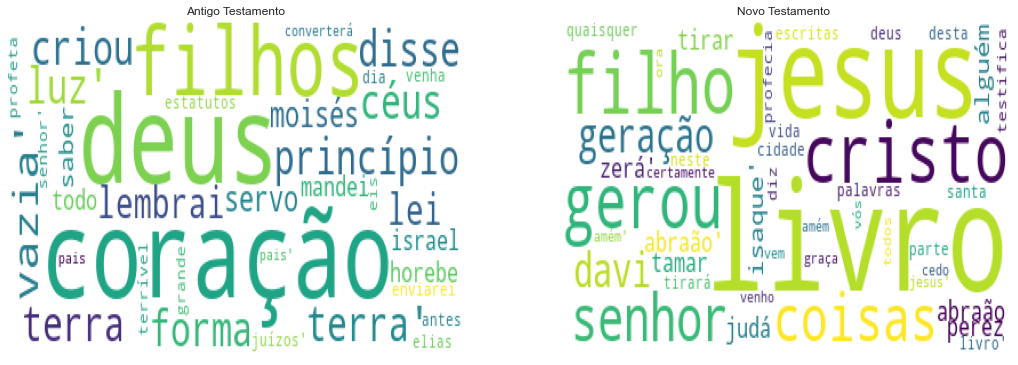

In [51]:
mpl.rcParams['figure.figsize']=(10,10)    
mpl.rcParams['font.size']=12                        
mpl.rcParams['figure.subplot.bottom']=.1 

OldTestament = df[df.testamento == 'antigo']
NewTestmanet = df[df.testamento == 'novo']

wordcloud_Old = WordCloud(background_color='white',stopwords=sw).generate(str(OldTestament.texto.values))
wordcloud_New = WordCloud(background_color='white',stopwords=sw).generate(str(NewTestmanet.texto.values))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax0, ax1 = ax.flatten()


ax1.imshow(wordcloud_New, aspect="auto")
ax1.title.set_text('Novo Testamento')
ax1.axis('off')

ax0.imshow(wordcloud_Old, aspect="auto")
ax0.title.set_text('Antigo Testamento')
ax0.axis('off')


plt.show()

Antigo testamento:
- deus
- coração
- filhos
- céus
- criou
- princípio

Novo testamento:
- livro
- jesus
- cristo
- senhor

Em comum:
- filho(s)
- senhor / deus


Alguns padrões interessantes entre os Testamentos:

* 'deus' ficou muito menor
* 'jesus' é grande no Novo Testamento, junto com 'Chirst'. A primeira palavra é usada principalmente nos Evangelhos, a segunda em 'Cartas dos Apóstolos'
* palavra 'face' e 'terra' são frequentemente usadas no Antigo Testamento, isso vem do círculo persa da cultura
* O Novo Testamento está cheio de nomes, é mais descritivo, dá informações sobre certas histórias com personagens reais. Por exemplo: 'jacó' (discípulo) ou thamar (mulher perto de Jesus)
* 'vazio' era a grande palavra no Antigo Testamento como contrária a 'terra'. Retrata a visão antiga do povo israelense sobre o mundo
* preste atenção a uma peculiaridade: 'abraham' aparece mais no Novo Testamento do que no antigo. Por quê? As pessoas são referidas como 'filhos de Abraão', então todas as pessoas são o centro desta atenção do Testamento. No Antigo Testamento, esse papel é assumido por 'Moisés', então apenas o povo israelense é relevante para a história
* próximo 'david' aparece muito no Novo Testamento, porque as origens de Jesus são de interesse, Jesus é muitas vezes referido como 'filho de Davi'
* característica da palavra bíblica 'amém' aparece quase que exclusivamente no Novo Testamento. Este id devido à língua grega koiné
* o centro dos tópicos do Antigo Testamento são 'julgamentos', 'servo', 'lei', 'estatutos', 'maldição'. Isso evolui muito para 'homem', 'vida', 'geração', 'graça'. Essas tags cobrem como a mensagem dos livros evolui ao longo dos séculos



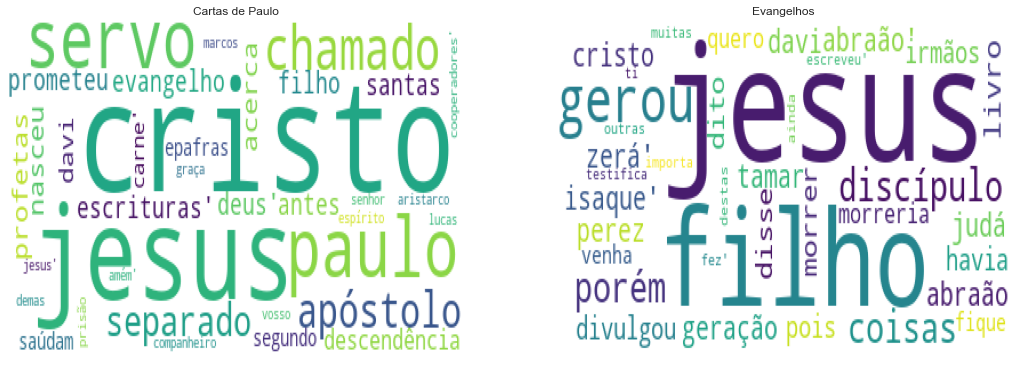

In [52]:
mpl.rcParams['figure.figsize']=(10,10)    
mpl.rcParams['font.size']=12                        
mpl.rcParams['figure.subplot.bottom']=.1 

paulo = df[df.autor == 'Paulo']
evangelho = df[df['livro'].isin(['Mateus', 'Marcos', 'Lucas', 'Joao'])]

wordcloud_paulo = WordCloud(background_color='white',stopwords=sw).generate(str(paulo.texto.values))
wordcloud_evangelho = WordCloud(background_color='white',stopwords=sw).generate(str(evangelho.texto.values))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax0, ax1 = ax.flatten()

ax0.imshow(wordcloud_paulo, aspect="auto")
ax0.title.set_text('Cartas de Paulo')
ax0.axis('off')

ax1.imshow(wordcloud_evangelho, aspect="auto")
ax1.title.set_text('Evangelhos')
ax1.axis('off')
plt.show()

**Destaques nas cartas de Paulo:**
- chamado
- apóstolo
- servo
- paulo

**Destaques nos evagelhos:**
- filho
- gerou (Mateus)
- discípulo
- coisas
- abraão / isaque

**Em comum:**
- Jesus
- Cristo
- filho
- davi

## 2.3. Plotagem de frequência

Em seguida, analiso a frequência de ocorrência de diferentes palavras na lista fornecida:

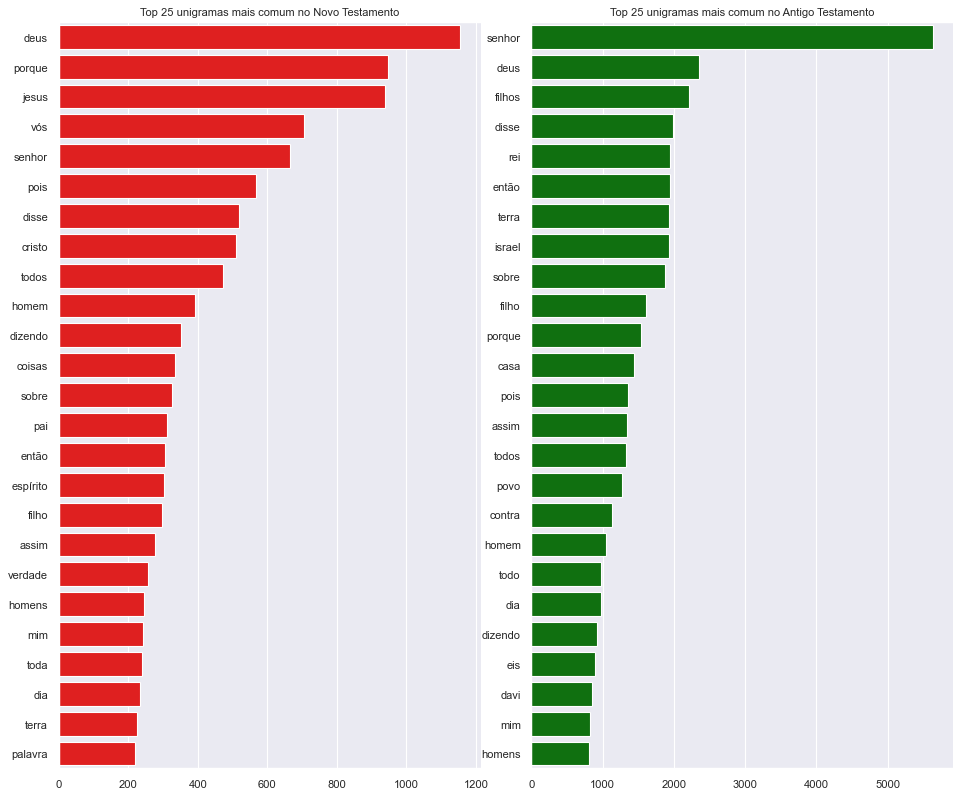

In [53]:
# Unigrams
NT_unigrams = defaultdict(int) #New Testament
OT_unigrams = defaultdict(int) #Old Testament

for line in NewTestmanet['t_lem']:
    for word in generate_ngrams(line):
        NT_unigrams[word] += 1
        
for line in OldTestament['t_lem']:
    for word in generate_ngrams(line):
        OT_unigrams[word] += 1
        
df_NT_unigrams = pd.DataFrame(sorted(NT_unigrams.items(), key=lambda x: x[1])[::-1])
df_OT_unigrams = pd.DataFrame(sorted(OT_unigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(12, 10), dpi=80)
plt.tight_layout()

N = 25

sns.barplot(y=df_NT_unigrams[0].values[:N], x=df_NT_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_OT_unigrams[0].values[:N], x=df_OT_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)
    
axes[0].set_title(f'Top {N} unigramas mais comum no Novo Testamento', fontsize=10)
axes[1].set_title(f'Top {N} unigramas mais comum no Antigo Testamento', fontsize=10)

plt.show()

Unigramas em comum nos dois testamentos:
- Deus
- Senhor
- todos
- homens

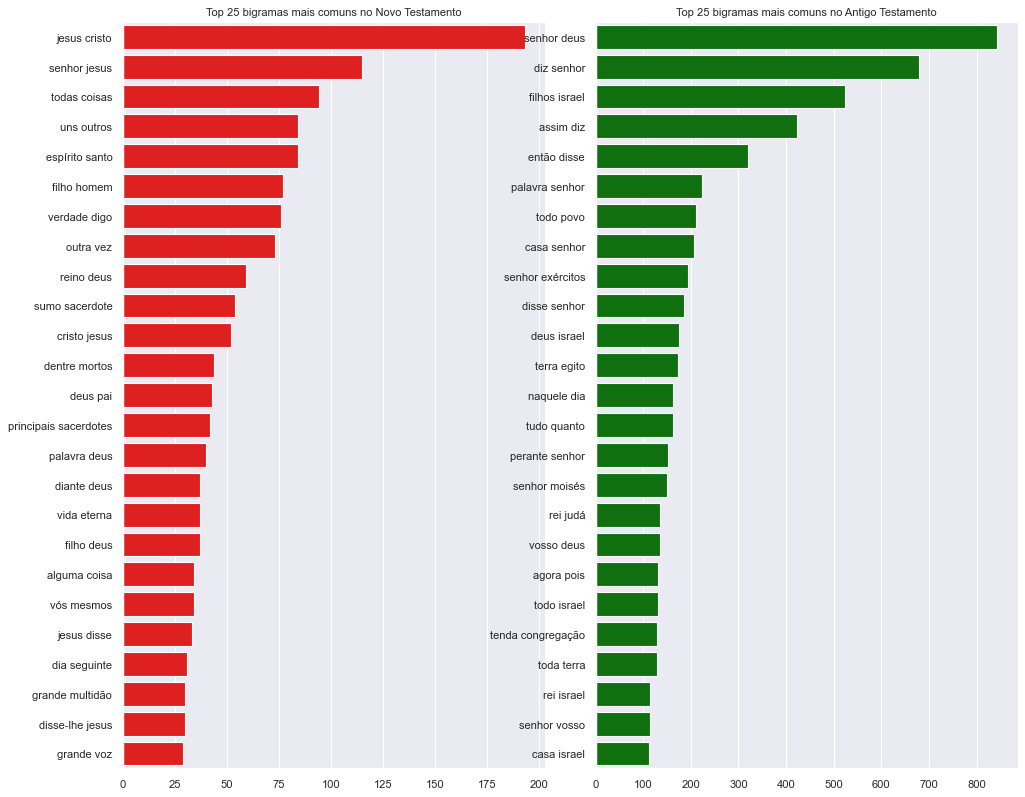

In [54]:
# Bigrams
NT_bigrams = defaultdict(int)
OT_bigrams = defaultdict(int)

for line in NewTestmanet['t_lem']:
    for word in generate_ngrams(line, n_gram=2):
        NT_bigrams[word] += 1
        
for line in OldTestament['t_lem']:
    for word in generate_ngrams(line, n_gram=2):
        OT_bigrams[word] += 1
        
df_NT_bigrams = pd.DataFrame(sorted(NT_bigrams.items(), key=lambda x: x[1])[::-1])
df_OT_bigrams = pd.DataFrame(sorted(OT_bigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(12, 10), dpi=80)
plt.tight_layout()

N = 25

sns.barplot(y=df_NT_bigrams[0].values[:N], x=df_NT_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_OT_bigrams[0].values[:N], x=df_OT_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)
    
axes[0].set_title(f'Top {N} bigramas mais comuns no Novo Testamento', fontsize=10)
axes[1].set_title(f'Top {N} bigramas mais comuns no Antigo Testamento', fontsize=10)

plt.show()

And the frequencies of trigrams:

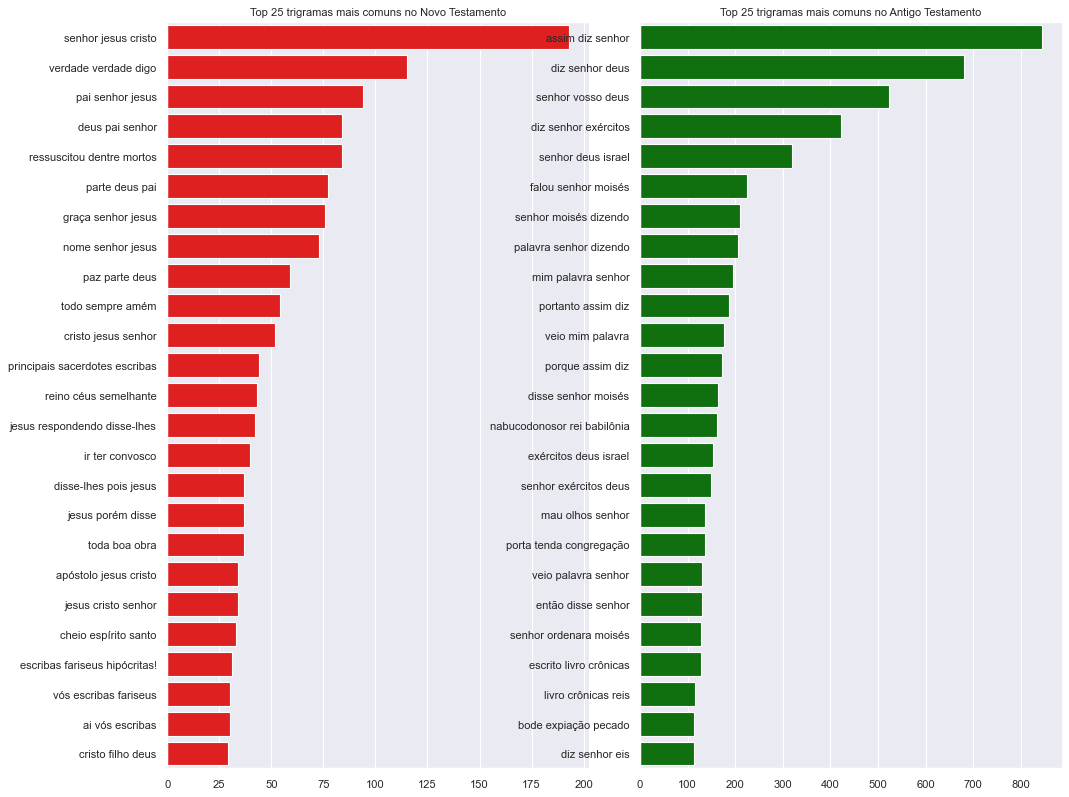

In [55]:
# Trigrams
NT_trigrams = defaultdict(int)
OT_trigrams = defaultdict(int)

for line in NewTestmanet['t_lem']:
    for word in generate_ngrams(line, n_gram=3):
        NT_trigrams[word] += 1
        
for line in OldTestament['t_lem']:
    for word in generate_ngrams(line, n_gram=3):
        OT_trigrams[word] += 1
        
df_NT_trigrams = pd.DataFrame(sorted(NT_trigrams.items(), key=lambda x: x[1])[::-1])
df_OT_trigrams = pd.DataFrame(sorted(OT_trigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(12, 10), dpi=80)
plt.tight_layout()

N = 25

sns.barplot(y=df_NT_trigrams[0].values[:N], x=df_NT_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_OT_trigrams[0].values[:N], x=df_OT_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)
    
axes[0].set_title(f'Top {N} trigramas mais comuns no Novo Testamento', fontsize=10)
axes[1].set_title(f'Top {N} trigramas mais comuns no Antigo Testamento', fontsize=10)

plt.show()

Analisar

## 2.4.Clustering and SVD

Eu uso vetorizador e decomposição de valor singular para criar clusters de texto e mesclá-los com os dados:

In [56]:
#Vetorizador (entender e explorar) [CONTA AS PRINCIPAIS PALAVRAS]
vectorizer = TfidfVectorizer(max_df = 0.5, max_features = 1000)
X = vectorizer.fit_transform(df.t_lem)
# Singular Value Decomposition (SVD) = reduz a dimensão
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X = svd.fit_transform(X)

cluster_data = pd.DataFrame({'Comp1': X[:,0], 'Comp2': X[:,1], 'Testamento': df.testamento, 'Livro': df.livro, 
                             'Periodo': df.periodo, 'Localizacao': df.localizacao, 'Tempo': df.tempo, 'Autor': df.autor})
cluster_data.head()

,Comp1,Comp2,Testamento,Livro,Periodo,Localizacao,Tempo,Autor
0,0.165215,0.046774,antigo,Genesis,Persian,Israel,-500,NaN
1,0.061559,-0.011067,antigo,Genesis,Persian,Israel,-500,NaN
2,0.079889,-0.071773,antigo,Genesis,Persian,Israel,-500,NaN
3,0.108524,-0.065496,antigo,Genesis,Persian,Israel,-500,NaN
4,0.070705,-0.028723,antigo,Genesis,Persian,Israel,-500,NaN


I observe how these clusters look by 'Testament' and by historical 'Period':

/Users/luisguilhermeribeiro/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luisguilhermeribeiro/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Por Periodo')

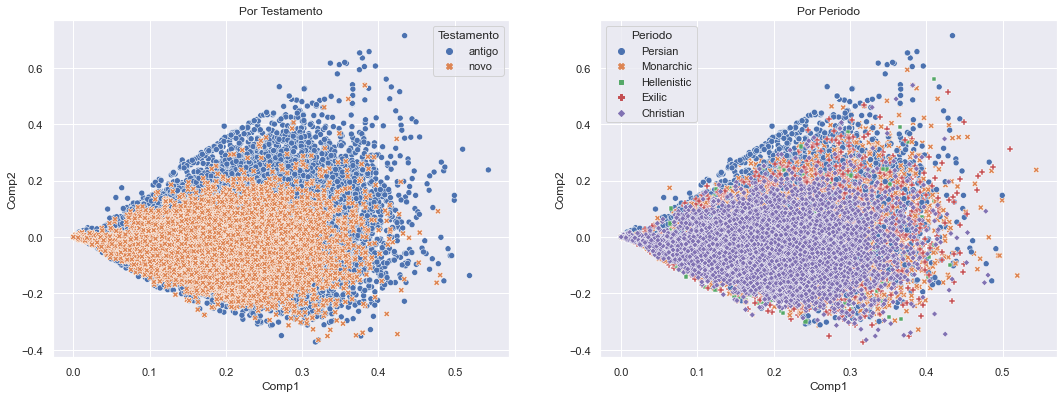

In [57]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.scatterplot('Comp1', 'Comp2', data=cluster_data, hue='Testamento', ax=axes[0], style="Testamento").set_title('Por Testamento')
sns.scatterplot('Comp1', 'Comp2', data=cluster_data, hue='Periodo', ax=axes[1], style="Periodo").set_title('Por Periodo')

Para os Testamentos, o Novo tem valores muito menos extremos e está centrado principalmente no meio. Ou seja, muitas estruturas de texto, que estavam presentes no Antigo, não estão presentes no Novo.

Além disso, posso olhar para este cluster também por livro, mas os resultados são confusos:

/Users/luisguilhermeribeiro/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


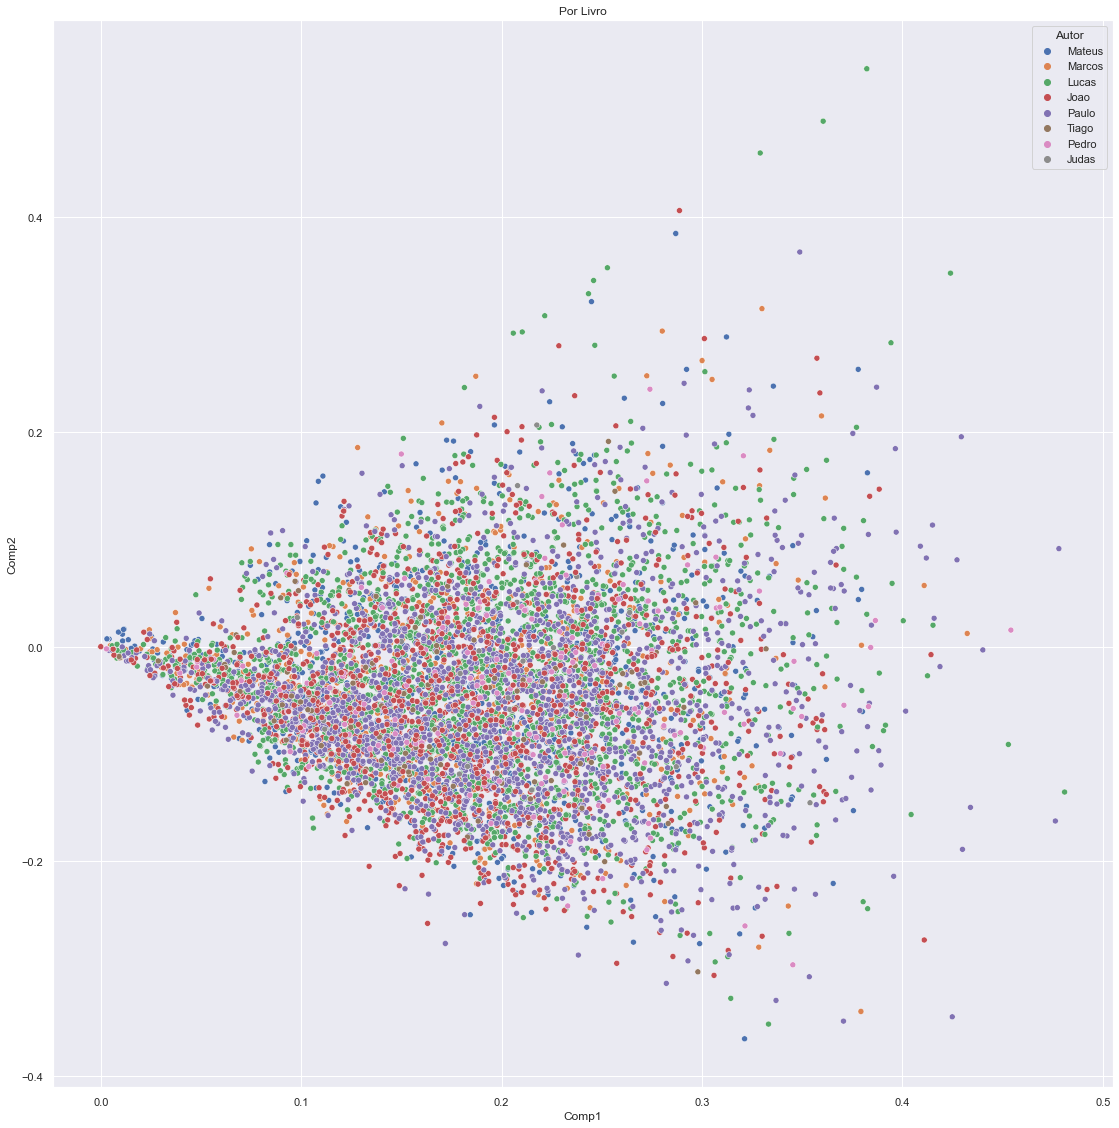

In [58]:
sns.set(rc={'figure.figsize':(19, 19)})
sns.scatterplot('Comp1', 'Comp2', data=cluster_data, hue='Autor').set_title('Por Livro')
plt.show()

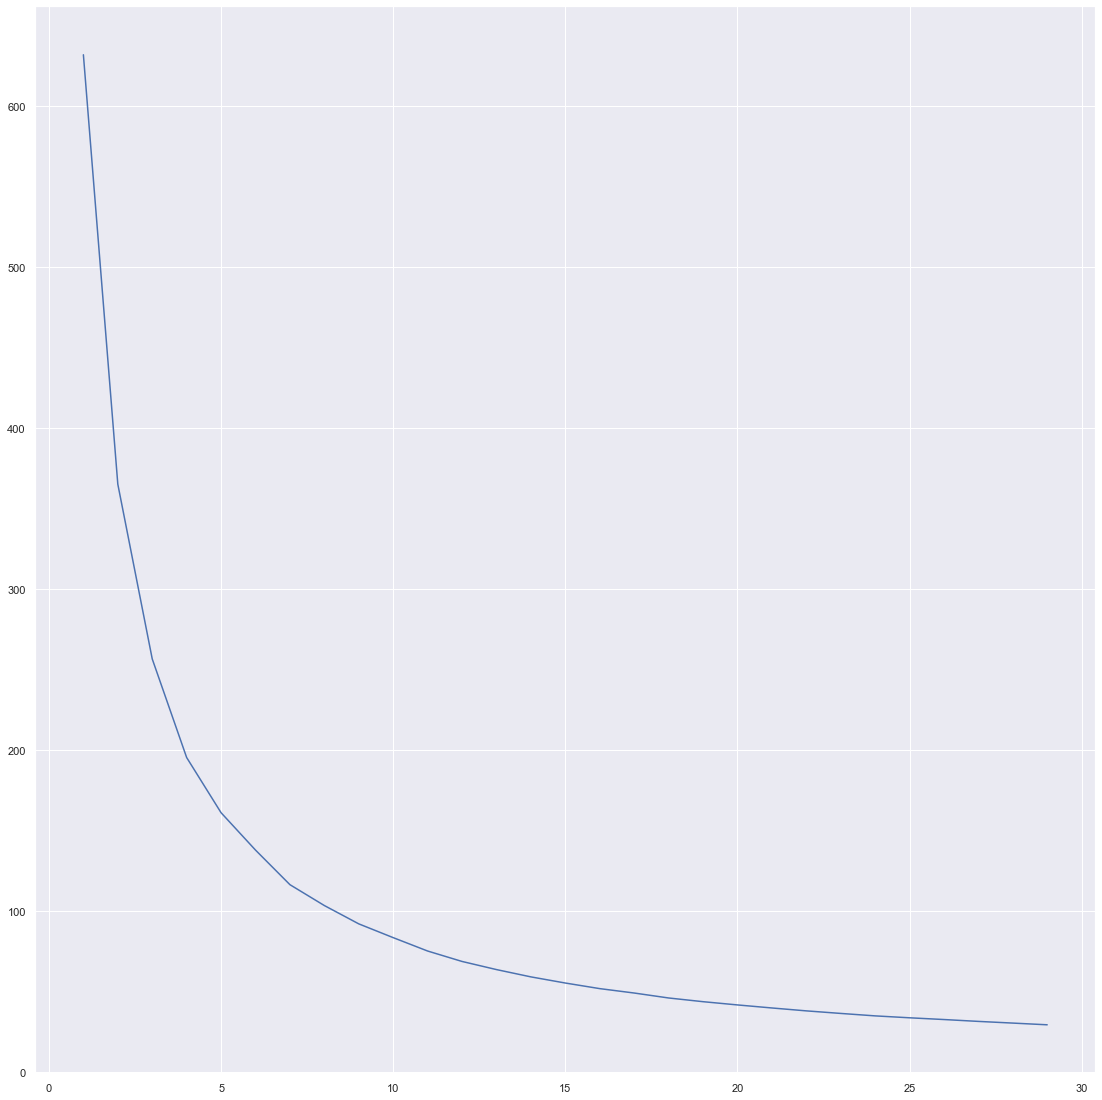

In [60]:
from sklearn.cluster import KMeans

wcss = []

for i in range(1, 30):
    clustering = KMeans(n_clusters=i, init='k-means++', random_state=42)
    clustering.fit(X)
    wcss.append(clustering.inertia_)
    
ks = range(1, 30)
sns.lineplot(x = ks, y = wcss);

In [61]:
kmeans = KMeans(n_clusters = 5)
kmeans.fit(X)
Counter(kmeans.labels_)

Counter({0: 5883, 3: 10162, 1: 7170, 4: 6023, 2: 2244})

In [62]:
df_cluster = df
df_cluster['cluster'] = kmeans.labels_

In [63]:
cts_paulo = df_cluster[df_cluster['autor'] == 'Paulo']['cluster'].value_counts()
idx = cts_paulo.index
i = 0
print('Paulo')
for x in cts_paulo:
    perc = round(x*100/sum(cts_paulo))
    print(idx[i], ' -> ',perc, '%')
    i = i +1

Paulo
1  ->  34 %
3  ->  32 %
4  ->  22 %
0  ->  11 %
2  ->  1 %


In [64]:
cts_lucas = df_cluster[df_cluster['autor'] == 'Lucas']['cluster'].value_counts()
idx = cts_lucas.index
i = 0
print('Lucas')
for x in cts_lucas:
    perc = round(x*100/sum(cts_lucas))
    print(idx[i], ' -> ',perc, '%')
    i = i +1

Lucas
3  ->  34 %
1  ->  25 %
4  ->  22 %
0  ->  16 %
2  ->  2 %


In [65]:
cts_hebreus = df_cluster[df_cluster['livro'] == 'Hebreus']['cluster'].value_counts()
idx = cts_hebreus.index
i = 0
print('Hebreus')
for x in cts_hebreus:
    perc = round(x*100/sum(cts_hebreus))
    print(idx[i], ' -> ',perc, '%')
    i = i +1

Hebreus
3  ->  32 %
1  ->  27 %
4  ->  23 %
0  ->  14 %
2  ->  3 %


O padrão dos clusters indicam que o Livro de Hebrues é mais semelhante com os livros do Lucas do que de Paulo

In [66]:
df

,cod,livro,capitulo,versiculo,texto,tempo,periodo,localizacao,testamento,t_lem,t_stem,t_stem_lem,palavras,autor,cluster
0,1,Genesis,1,1,no princípio criou deus os céus e a terra,-500,Persian,Israel,antigo,no princípio criou deus os céus e a terra,no princípio criou deu os céu e a terra,no princípio criou deu os céu e a terra,9,NaN,0
1,1,Genesis,1,2,e a terra era sem forma e vazia,-500,Persian,Israel,antigo,e a terra era sem forma e vazia,e a terra era sem forma e vazia,e a terra era sem forma e vazia,8,NaN,3
2,1,Genesis,1,3,e disse deus haja luz,-500,Persian,Israel,antigo,e disse deus haja luz,e diss deu haja luz,e diss deu haja luz,5,NaN,3
3,1,Genesis,1,4,e viu deus que era boa a luz,-500,Persian,Israel,antigo,e viu deus que era boa a luz,e viu deu que era boa a luz,e viu deu que era boa a luz,8,NaN,3
4,1,Genesis,1,5,e deus chamou à luz dia,-500,Persian,Israel,antigo,e deus chamou à luz dia,e deu chamou à luz dia,e deu chamou à luz dia,6,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31477,66,Apocalipse,22,17,e o espírito e a esposa dizem vem e quem ouve ...,95,Christian,Patmos,novo,e o espírito e a esposa dizem vem e quem ouve ...,e o espírito e a esposa dizem vem e quem ouv d...,e o espírito e a esposa dizem vem e quem ouv d...,18,Joao,3
31478,66,Apocalipse,22,18,porque eu testifico a todo aquele que ouvir as...,95,Christian,Patmos,novo,porque eu testifico a todo aquele que ouvir as...,porqu eu testifico a todo aquel que ouvir as p...,porqu eu testifico a todo aquel que ouvir as p...,33,Joao,1
31479,66,Apocalipse,22,19,e se alguém tirar quaisquer palavras do livro ...,95,Christian,Patmos,novo,e se alguém tirar quaisquer palavras do livro ...,e se alguém tirar quaisquer palavra do livro d...,e se alguém tirar quaisquer palavra do livro d...,31,Joao,3
31480,66,Apocalipse,22,20,aquele que testifica estas coisas diz certamen...,95,Christian,Patmos,novo,aquele que testifica estas coisas diz certamen...,aquel que testifica esta coisa diz certament c...,aquel que testifica esta coisa diz certament c...,14,Joao,3


# Análise de sentimentos

## TextBlob

**Polarity** is a float in the range [-1.0, 1.0] where **-1 is the most negative and 1 is the most positive.**

**Subjectivity** is a float in the range [0.0, 1.0] where **0.0 is very objective and 1.0 is very subjective.**


## VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media
**Compound** is a float in range [-1, 1] where **-1 is the most negative and 1 is the most positive.**

In [68]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from googletrans import Translator

analyzer= SentimentIntensityAnalyzer()

In [69]:
df_paulo = df[df.autor == 'Paulo']
df_evangelho = df[df['livro'].isin(['Mateus', 'Marcos', 'Lucas', 'Joao'])]
df_evangelho

,cod,livro,capitulo,versiculo,texto,tempo,periodo,localizacao,testamento,t_lem,t_stem,t_stem_lem,palavras,autor,cluster
23524,40,Mateus,1,1,livro da geração de jesus cristo filho de davi...,80,Christian,Israel,novo,livro da geração de jesus cristo filho de davi...,livro da geração de jesu cristo filho de davi ...,livro da geração de jesu cristo filho de davi ...,12,Mateus,2
23525,40,Mateus,1,2,abraão gerou a isaque,80,Christian,Israel,novo,abraão gerou a isaque,abraão gerou a isaqu,abraão gerou a isaqu,4,Mateus,3
23526,40,Mateus,1,3,e judá gerou de tamar a perez e a zerá,80,Christian,Israel,novo,e judá gerou de tamar a perez e a zerá,e judá gerou de tamar a perez e a zerá,e judá gerou de tamar a perez e a zerá,10,Mateus,0
23527,40,Mateus,1,4,e arão gerou a aminadabe,80,Christian,Israel,novo,e arão gerou a aminadabe,e arão gerou a aminadab,e arão gerou a aminadab,5,Mateus,3
23528,40,Mateus,1,5,e salmom gerou de raabe a boaz,80,Christian,Israel,novo,e salmom gerou de raabe a boaz,e salmom gerou de raab a boaz,e salmom gerou de raab a boaz,7,Mateus,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27298,43,Joao,21,21,vendo pedro a este disse a jesus senhor e dest...,90,Christian,Patmos,novo,vendo pedro a este disse a jesus senhor e dest...,vendo pedro a est diss a jesu senhor e dest qu...,vendo pedro a est diss a jesu senhor e dest qu...,12,Joao,1
27299,43,Joao,21,22,disse-lhe jesus se eu quero que ele fique até ...,90,Christian,Patmos,novo,disse-lhe jesus se eu quero que ele fique até ...,disse-lh jesu se eu quero que ele fiqu até que...,disse-lh jesu se eu quero que ele fiqu até que...,19,Joao,1
27300,43,Joao,21,23,divulgou-se pois entre os irmãos este dito que...,90,Christian,Patmos,novo,divulgou-se pois entre os irmãos este dito que...,divulgou-s poi entr os irmão est dito que aque...,divulgou-s poi entr os irmão est dito que aque...,38,Joao,1
27301,43,Joao,21,24,este é o discípulo que testifica destas coisas...,90,Christian,Patmos,novo,este é o discípulo que testifica destas coisas...,est é o discípulo que testifica desta coisa e ...,est é o discípulo que testifica desta coisa e ...,11,Joao,3


In [70]:
def translate_to_en(val):
    translator = Translator()
    return translator.translate(val, src="pt", dest="en").text

In [73]:
def get_sentiment(row):
    val = row['texto']
    blob = TextBlob(translate_to_en(val))
    row['polaridade'] = blob.sentiment.polarity
    row['subjetividade'] = blob.sentiment.subjectivity
    row['compound'] = analyzer.polarity_scores(val)['compound']
    return row

In [74]:
df_evangelho = df_evangelho.apply(lambda row: get_sentiment(row), axis=1)
df_evangelho

,cod,livro,capitulo,versiculo,texto,tempo,periodo,localizacao,testamento,t_lem,t_stem,t_stem_lem,palavras,autor,cluster,polaridade,subjetividade,compound
23524,40,Mateus,1,1,livro da geração de jesus cristo filho de davi...,80,Christian,Israel,novo,livro da geração de jesus cristo filho de davi...,livro da geração de jesu cristo filho de davi ...,livro da geração de jesu cristo filho de davi ...,12,Mateus,2,0.0000,0.0000,0.0
23525,40,Mateus,1,2,abraão gerou a isaque,80,Christian,Israel,novo,abraão gerou a isaque,abraão gerou a isaqu,abraão gerou a isaqu,4,Mateus,3,0.0000,0.0000,0.0
23526,40,Mateus,1,3,e judá gerou de tamar a perez e a zerá,80,Christian,Israel,novo,e judá gerou de tamar a perez e a zerá,e judá gerou de tamar a perez e a zerá,e judá gerou de tamar a perez e a zerá,10,Mateus,0,0.0000,0.0000,0.0
23527,40,Mateus,1,4,e arão gerou a aminadabe,80,Christian,Israel,novo,e arão gerou a aminadabe,e arão gerou a aminadab,e arão gerou a aminadab,5,Mateus,3,0.0000,0.0000,0.0
23528,40,Mateus,1,5,e salmom gerou de raabe a boaz,80,Christian,Israel,novo,e salmom gerou de raabe a boaz,e salmom gerou de raab a boaz,e salmom gerou de raab a boaz,7,Mateus,0,0.0000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27298,43,Joao,21,21,vendo pedro a este disse a jesus senhor e dest...,90,Christian,Patmos,novo,vendo pedro a este disse a jesus senhor e dest...,vendo pedro a est diss a jesu senhor e dest qu...,vendo pedro a est diss a jesu senhor e dest qu...,12,Joao,1,0.0000,0.0000,0.0
27299,43,Joao,21,22,disse-lhe jesus se eu quero que ele fique até ...,90,Christian,Patmos,novo,disse-lhe jesus se eu quero que ele fique até ...,disse-lh jesu se eu quero que ele fiqu até que...,disse-lh jesu se eu quero que ele fiqu até que...,19,Joao,1,0.0000,0.0000,0.0
27300,43,Joao,21,23,divulgou-se pois entre os irmãos este dito que...,90,Christian,Patmos,novo,divulgou-se pois entre os irmãos este dito que...,divulgou-s poi entr os irmão est dito que aque...,divulgou-s poi entr os irmão est dito que aque...,38,Joao,1,0.0000,0.0000,0.0
27301,43,Joao,21,24,este é o discípulo que testifica destas coisas...,90,Christian,Patmos,novo,este é o discípulo que testifica destas coisas...,est é o discípulo que testifica desta coisa e ...,est é o discípulo que testifica desta coisa e ...,11,Joao,3,0.0000,0.0000,0.0


In [75]:
df_evangelho.describe()

,cod,capitulo,versiculo,tempo,palavras,cluster,polaridade,subjetividade,compound
count,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000,3779.000000
mean,41.486372,12.148981,23.724001,79.634824,16.333951,2.159831,0.045612,0.219022,-0.020890
std,1.132331,7.216407,15.511733,7.969404,7.035540,1.350790,0.238244,0.305632,0.113033
min,40.000000,1.000000,1.000000,65.000000,1.000000,0.000000,-1.000000,0.000000,-0.680800
25%,40.000000,6.000000,11.000000,80.000000,11.000000,1.000000,0.000000,0.000000,0.000000
50%,42.000000,11.000000,22.000000,80.000000,16.000000,3.000000,0.000000,0.000000,0.000000
75%,42.000000,18.000000,34.000000,80.000000,21.000000,3.000000,0.000000,0.482292,0.000000
max,43.000000,28.000000,80.000000,90.000000,51.000000,4.000000,1.000000,1.000000,0.840200


<AxesSubplot:>

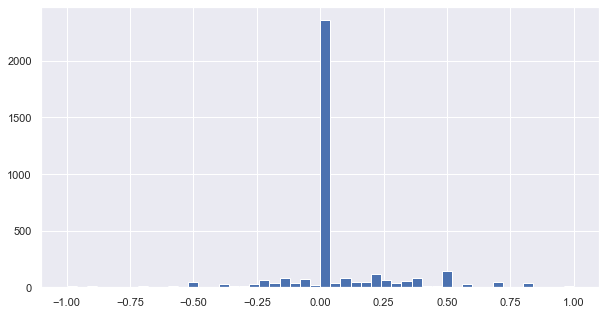

In [79]:
plt.figure(figsize=(10,5))
df_evangelho['polaridade'].hist(bins=50)

<AxesSubplot:>

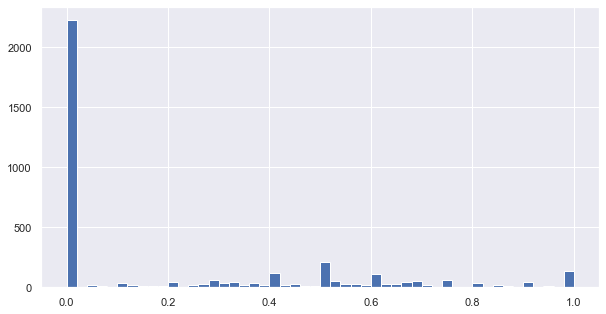

In [81]:
plt.figure(figsize=(10,5))
df_evangelho['subjetividade'].hist(bins=50)

Média (Mateus):  0.042  +-  0.255
Média (Marcos):  0.047  +-  0.228
Média (Lucas):  0.05  +-  0.243
Média (Joao):  0.042  +-  0.219


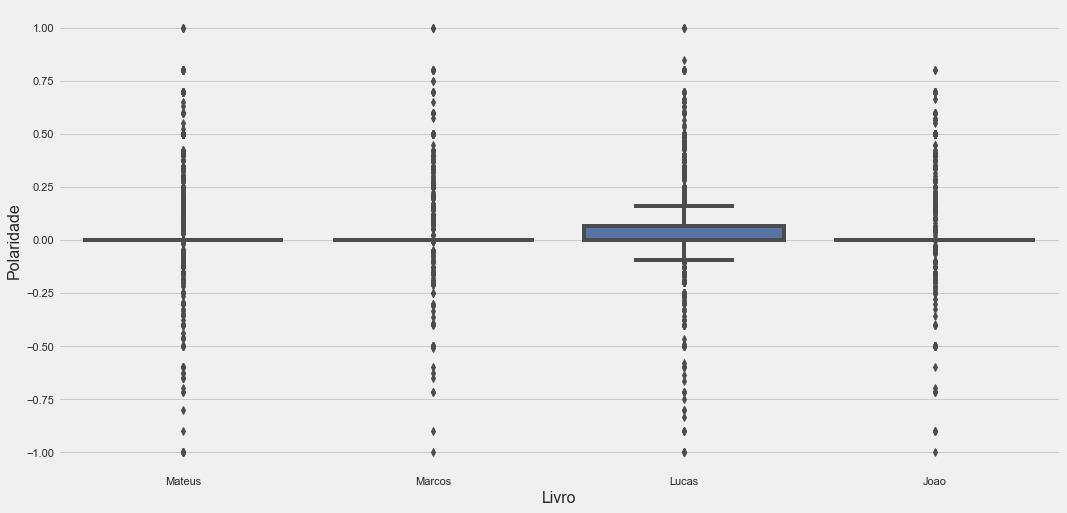

In [96]:
media = round(df_evangelho[df_evangelho['livro']=='Mateus']['polaridade'].mean(),3)
desvio = round(df_evangelho[df_evangelho['livro']=='Mateus']['polaridade'].std(),3)
print('Média (Mateus): ',media, ' +- ',desvio)

media = round(df_evangelho[df_evangelho['livro']=='Marcos']['polaridade'].mean(),3)
desvio = round(df_evangelho[df_evangelho['livro']=='Marcos']['polaridade'].std(),3)
print('Média (Marcos): ',media, ' +- ',desvio)

media = round(df_evangelho[df_evangelho['livro']=='Lucas']['polaridade'].mean(),3)
desvio = round(df_evangelho[df_evangelho['livro']=='Lucas']['polaridade'].std(),3)
print('Média (Lucas): ',media, ' +- ',desvio)

media = round(df_evangelho[df_evangelho['livro']=='Joao']['polaridade'].mean(),3)
desvio = round(df_evangelho[df_evangelho['livro']=='Joao']['polaridade'].std(),3)
print('Média (Joao): ',media, ' +- ',desvio)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
sns.despine(left=True)
g = sns.boxplot(x=df_evangelho['livro'], y=df_evangelho['polaridade'], palette=['r','g','b','y']) #Violin Plot
g.set_xlabel('Livro', fontsize=16)
g.set_ylabel('Polaridade', fontsize=16)
plt.show()

Média (Mateus):  0.23  +-  0.314
Média (Marcos):  0.217  +-  0.298
Média (Lucas):  0.227  +-  0.313
Média (Joao):  0.197  +-  0.29


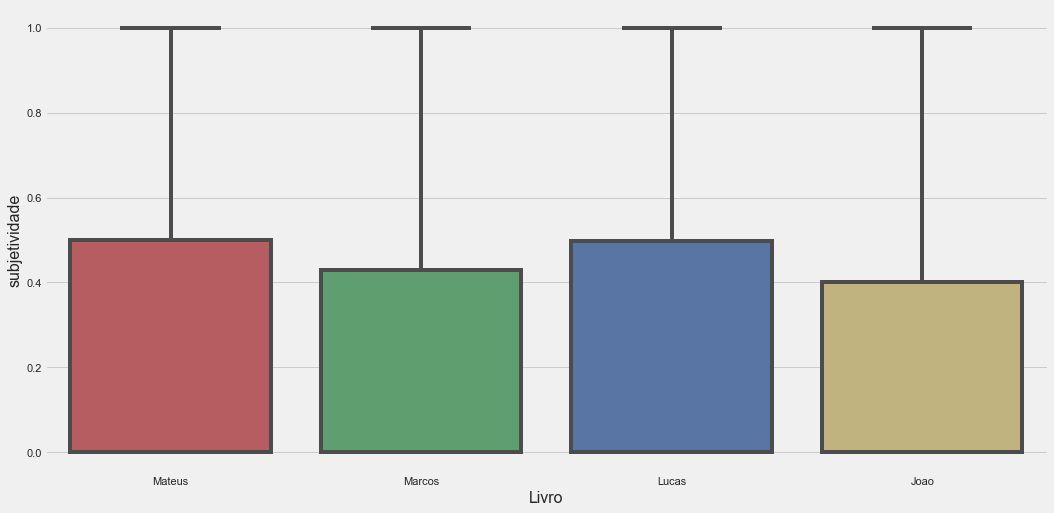

In [101]:
media = round(df_evangelho[df_evangelho['livro']=='Mateus']['subjetividade'].mean(),3)
desvio = round(df_evangelho[df_evangelho['livro']=='Mateus']['subjetividade'].std(),3)
print('Média (Mateus): ',media, ' +- ',desvio)

media = round(df_evangelho[df_evangelho['livro']=='Marcos']['subjetividade'].mean(),3)
desvio = round(df_evangelho[df_evangelho['livro']=='Marcos']['subjetividade'].std(),3)
print('Média (Marcos): ',media, ' +- ',desvio)

media = round(df_evangelho[df_evangelho['livro']=='Lucas']['subjetividade'].mean(),3)
desvio = round(df_evangelho[df_evangelho['livro']=='Lucas']['subjetividade'].std(),3)
print('Média (Lucas): ',media, ' +- ',desvio)

media = round(df_evangelho[df_evangelho['livro']=='Joao']['subjetividade'].mean(),3)
desvio = round(df_evangelho[df_evangelho['livro']=='Joao']['subjetividade'].std(),3)
print('Média (Joao): ',media, ' +- ',desvio)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
sns.despine(left=True)
g = sns.boxplot(x=df_evangelho['livro'], y=df_evangelho['subjetividade'], palette=['r','g','b','y']) #Violin Plot
g.set_xlabel('Livro', fontsize=16)
g.set_ylabel('subjetividade', fontsize=16)
plt.show()

In [102]:
df_paulo = df_paulo.apply(lambda row: get_sentiment(row), axis=1)
df_paulo.describe()

,cod,livro,capitulo,versiculo,texto,tempo,periodo,localizacao,testamento,t_lem,t_stem,t_stem_lem,palavras,autor,cluster,polaridade,subjetividade,compound
28310,45,Romanos,1,1,paulo servo de jesus cristo chamado para apóst...,57,Christian,Corinto,novo,paulo servo de jesus cristo chamado para apóst...,paulo servo de jesu cristo chamado para apósto...,paulo servo de jesu cristo chamado para apósto...,14,Paulo,0,0.0,0.000000,0.0
28311,45,Romanos,1,2,o qual antes prometeu pelos seus profetas nas ...,57,Christian,Corinto,novo,o qual ante prometeu pelos seus profetas nas s...,o qual ant prometeu pelo seu profeta na santa ...,o qual ant prometeu pelo seu profeta na santa ...,10,Paulo,3,0.0,0.000000,0.0
28312,45,Romanos,1,3,acerca de seu filho que nasceu da descendência...,57,Christian,Corinto,novo,acerca de seu filho que nasceu da descendência...,acerca de seu filho que nasceu da descendência...,acerca de seu filho que nasceu da descendência...,13,Paulo,0,0.0,0.000000,0.0
28313,45,Romanos,1,4,declarado filho de deus em poder segundo o esp...,57,Christian,Corinto,novo,declarado filho de deus em poder segundo o esp...,declarado filho de deu em poder segundo o espí...,declarado filho de deu em poder segundo o espí...,19,Paulo,4,-0.2,0.400000,0.0
28314,45,Romanos,1,5,pelo qual recebemos a graça e o apostolado par...,57,Christian,Corinto,novo,pelo qual recebemos a graça e o apostolado par...,pelo qual recebemo a graça e o apostolado para...,pelo qual recebemo a graça e o apostolado para...,20,Paulo,3,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30337,57,Filemom,1,21,escrevi-te confiado na tua obediência sabendo ...,54,Christian,Roma,novo,escrevi-te confiado na tua obediência sabendo ...,escrevi-t confiado na tua obediência sabendo q...,escrevi-t confiado na tua obediência sabendo q...,13,Paulo,1,0.5,0.666667,0.0
30338,57,Filemom,1,22,e juntamente prepara-me também pousada porque ...,54,Christian,Roma,novo,e juntamente prepara-me também pousada porque ...,e juntament prepara-m também pousada porqu esp...,e juntament prepara-m também pousada porqu esp...,16,Paulo,3,0.0,0.000000,0.0
30339,57,Filemom,1,23,saúdam-te epafras meu companheiro de prisão po...,54,Christian,Roma,novo,saúdam-te epafras meu companheiro de prisão po...,saúdam-t epafra meu companheiro de prisão por ...,saúdam-t epafra meu companheiro de prisão por ...,9,Paulo,4,0.0,0.000000,0.0
30340,57,Filemom,1,24,marcos aristarco demas e lucas meus cooperadores,54,Christian,Roma,novo,marcos aristarco demas e lucas meus cooperadores,marco aristarco dema e luca meu cooperador,marco aristarco dema e luca meu cooperador,7,Paulo,3,0.0,0.000000,0.0


In [103]:
df_paulo.describe()

,cod,capitulo,versiculo,tempo,palavras,cluster,polaridade,subjetividade,compound
count,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000
mean,48.325787,5.991142,13.491142,61.745079,17.653543,2.197835,0.108331,0.302488,-0.001496
std,3.351575,4.467170,9.085020,15.880802,7.216839,1.385454,0.271794,0.339020,0.161452
min,45.000000,1.000000,1.000000,48.000000,2.000000,0.000000,-1.000000,0.000000,-0.661900
25%,46.000000,2.000000,6.000000,53.000000,12.000000,1.000000,0.000000,0.000000,0.000000
50%,47.000000,4.500000,12.000000,55.000000,17.000000,3.000000,0.000000,0.162500,0.000000
75%,50.000000,9.000000,19.000000,57.000000,22.000000,3.000000,0.225000,0.600000,0.000000
max,57.000000,16.000000,58.000000,100.000000,47.000000,4.000000,1.000000,1.000000,0.840200


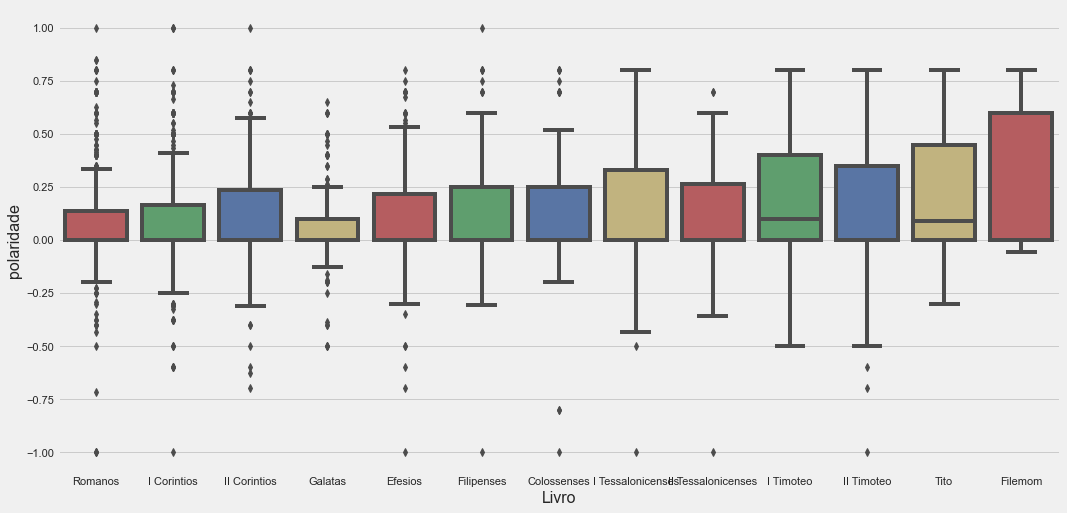

In [106]:

plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
sns.despine(left=True)
g = sns.boxplot(x=df_paulo['livro'], y=df_paulo['polaridade'], palette=['r','g','b','y']) #Violin Plot
g.set_xlabel('Livro', fontsize=16)
g.set_ylabel('polaridade', fontsize=16)
plt.show()

<AxesSubplot:xlabel='livro'>

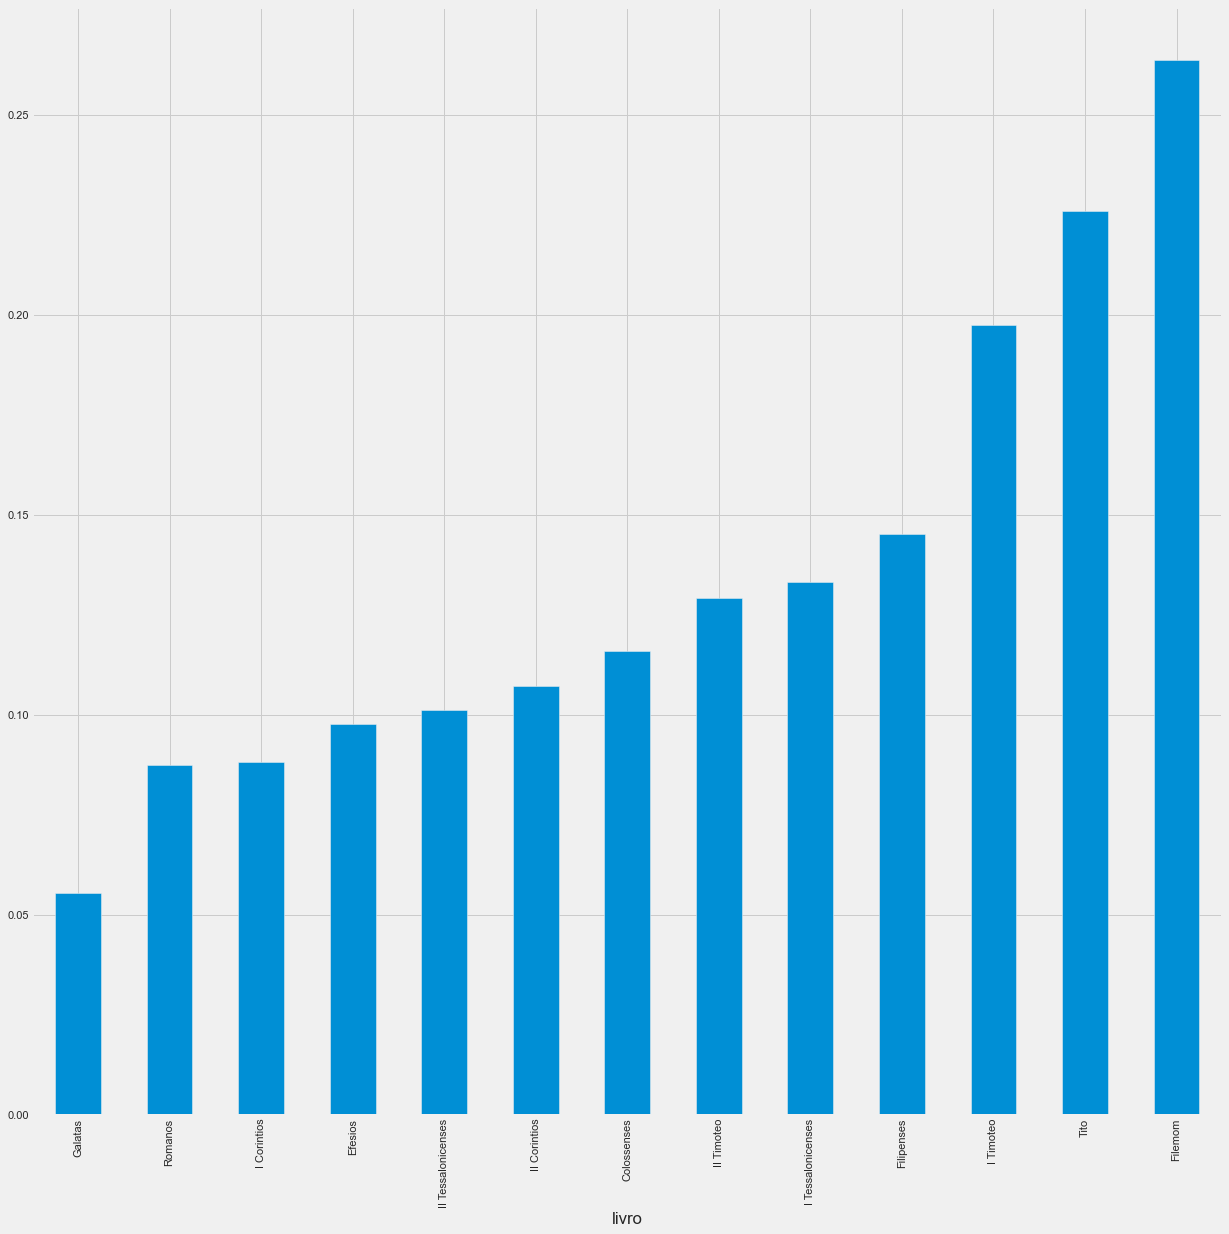

In [121]:
df_paulo_agg = df_paulo.groupby('livro').agg({'polaridade':'mean','subjetividade':'mean'})
df_paulo_agg.sort_values(by=['polaridade'])['polaridade'].plot(kind='bar', sort_columns=True)


<AxesSubplot:xlabel='livro'>

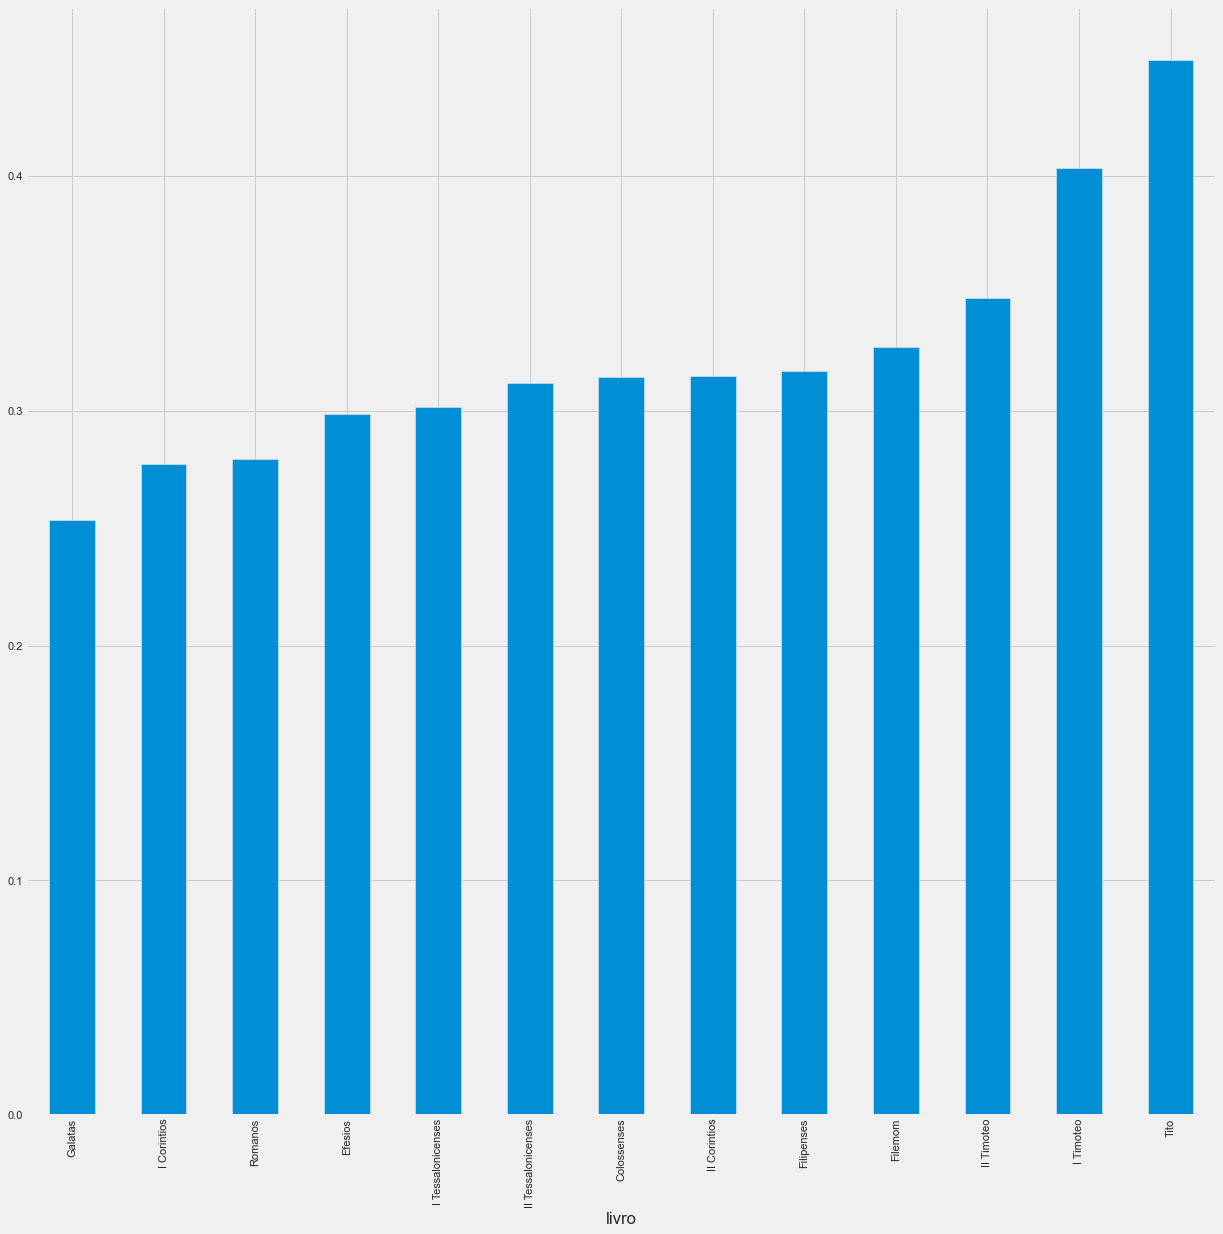

In [122]:
df_paulo_agg.sort_values(by=['subjetividade'])['subjetividade'].plot(kind='bar', sort_columns=True)


Análise

## Identificação de entidades

**Ideias:**
- Analisar cartas de Paulo (nuvem de palavras, cluster) [OK]
- Identificar frases de Jesus (Evangelhos, procurar padrões)
- Cluster por Autor [OK]
- Análise de sentimento em frases [OK]
- Análise de parábolas
- Detectar autor dos livros que não possui um autor concreto (Hebreus) [OK]
    - Paulo de Tarso ou Lucas, Clemente de Roma ou Barnabé

**Técnicas:**
- Análise de sentimentos
    - BERT (https://www.kaggle.com/code/abhinand05/bert-for-humans-tutorial-baseline)
    - TextBlob
    - VADER
- Identificação de entidades
    - https://www.kaggle.com/code/fernandojvdasilva/aplica-es-em-nlp-aula-06/notebook
- Clusterização [OK]
    - SVD + Kmeans
- Resumo de Texto
- Lematização Stematização
    - https://www.youtube.com/watch?v=J7s1xLsDfWQ